In [2]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

data = pd.merge(X_train, y_train, right_on='Unnamed: 0', left_on='Unnamed: 0')
data.sort_values(by='Unnamed: 0', inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)

X = data.drop('LeaveOrNot', axis=1)
y = data['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

## Pipline

In [4]:
data

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race,LeaveOrNot
2800,Bachelors,2017,Bangalore,3,NaN,NaN,No,0,0,white,0
2969,Bachelors,2013,Pune,1,NaN,NaN,No,3,1,white,1
61,Masters,2017,Pune,3,26.0,Male,Yes,2,4,white,1
4,Bachelors,2016,Bangalore,3,24.0,Male,No,0,5,white,0
1346,Bachelors,2015,New Delhi,3,40.0,Male,No,0,6,white,0
...,...,...,...,...,...,...,...,...,...,...,...
1271,Bachelors,2013,Bangalore,3,27.0,Female,No,3,4646,white,0
1535,Bachelors,2013,Bangalore,3,27.0,Female,No,4,4648,black,0
123,Masters,2013,Pune,2,39.0,Male,No,2,4649,black,1
1813,Masters,2018,New Delhi,3,28.0,Male,No,5,4650,white,1


In [5]:
def drop_col(df):
  clean_df = df.drop('id', axis=1)
  return clean_df

func_transformer = FunctionTransformer(drop_col)


numeric_transformer = Pipeline(steps=[('imputer_num', SimpleImputer(strategy="mean")),
                                      ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                          ('onehot', OneHotEncoder())])

NUM_COLS = ['JoiningYear', 'Age', 'ExperienceInCurrentDomain']
CAT_COLS = ['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'Race']

# Combine transformers using ColumnTransformer
column_transformer = ColumnTransformer(transformers=[('num', numeric_transformer, NUM_COLS),
                                                     ('cat', categorical_transformer, CAT_COLS)])

# The final pipeline
preprocess_pipeline = Pipeline(steps=[('drop_id', func_transformer),
                                      ('col_transformer', column_transformer)])

preprocess_pipeline

Pipeline(steps=[('drop_id',
                 FunctionTransformer(func=<function drop_col at 0x000002751C89C900>)),
                ('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['JoiningYear', 'Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Education', 'City',
                                                   'PaymentTier', 'Gender',
                                                   'EverBenched', 'Race'])]))])

## **Decision Tree Classifier**

In [21]:
dt_clf = DecisionTreeClassifier(random_state=42)

dt_pipeline = Pipeline([('trans_pipeline', preprocess_pipeline),
                          ('dt', dt_clf)])

# applying grid search
params = {'dt__max_depth': [10,25,50,100],
          'dt__min_samples_leaf':[5,10,20,50],
          'dt__min_samples_split':[15,20,50,100]}

gs = GridSearchCV(dt_pipeline, param_grid=params, cv=10, scoring='f1')

gs.fit(X_train, y_train)

best_clf = gs.best_estimator_
best_params = gs.best_params_
best_f1_score = gs.best_score_

print("best f1 score:", best_f1_score)
print("Best Parameters:", best_params)

best f1 score: 0.7454935359877153
Best Parameters: {'dt__max_depth': 10, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 15}


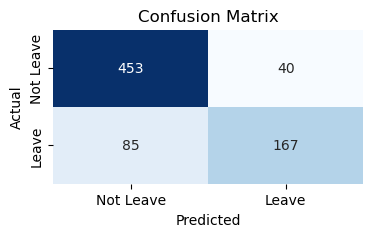

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       493
           1       0.81      0.66      0.73       252

    accuracy                           0.83       745
   macro avg       0.82      0.79      0.80       745
weighted avg       0.83      0.83      0.83       745



In [7]:
# Make predictions using the best estimator
y_pred = best_clf.predict(X_test)

# Evaluate the model using confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Leave', 'Leave'], yticklabels=['Not Leave', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

In [8]:
###### not working - feature importance ######

# Assuming 'best_clf' is the best estimator from GridSearchCV
# best_dt_clf = best_clf.named_steps['dt']

# feature_importances = pd.Series(best_dt_clf.feature_importances_, index=X.columns)

# print(feature_importances)


## **Random Forest**

In [22]:
# Replace DecisionTreeClassifier with RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Modify the pipeline to use the RandomForestClassifier
rf_pipeline = Pipeline([('trans_pipeline', preprocess_pipeline),
                        ('rf', rf_clf)])

# Grid search parameters for the Random Forest
params_rf = {'rf__n_estimators': [50, 100, 200],
             'rf__max_depth': [10,25,50],
             'rf__min_samples_leaf':[5,10,20],
             'rf__min_samples_split':[15,20,50]}



# Grid search with the Random Forest pipeline
gs_rf = GridSearchCV(rf_pipeline, param_grid=params_rf, cv=10, scoring='f1')
gs_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf_clf = gs_rf.best_estimator_
best_f1_score = gs_rf.best_score_

print("best_f1_score:", best_f1_score)

best_f1_score: 0.7513698794283632


AUC: 0.8654174313403522


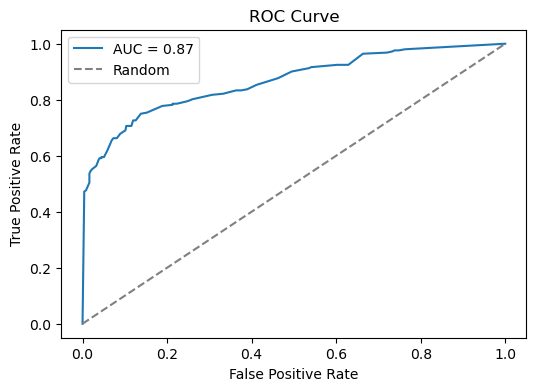

In [13]:
# Make predictions using the best estimator
y_pred = best_clf.predict(X_test)

# Calculate predicted probabilities for the "1" class (leave)
y_proba = best_clf.predict_proba(X_test)[:, 1]

# AUC
auc = roc_auc_score(y_test, y_proba)
print("AUC:", auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## **Logistic Regression Model**

In [14]:
# C= Regularization Strength. a large 'C' means you want a smoother curve that captures
# the general trend without fitting each point precisely
# tol= Tolerance for Stopping Criteria. A larger 'tol' means you're willing to stop
# when you are reasonably close, even if you haven't found the absolute best solution.

lr_model = LogisticRegression()

lr_pipeline = Pipeline([('trans_pipeline', preprocess_pipeline),
                          ('logistic_regression', lr_model)])


lr_params = {'logistic_regression__C': [1, 5, 10],
             'logistic_regression__tol': [0.001, 0.0001, 0.00001]}


gs = GridSearchCV(lr_pipeline, param_grid=lr_params, cv=20, scoring='f1')

gs.fit(X_train, y_train)

# the best model
best_clf = gs.best_estimator_

f1_score = gs.best_score_
best_params = gs.best_params_

print("best f1 score:", f1_score)
print("Best Parameters:", best_params)

best f1 score: 0.5292310483234843
Best Parameters: {'logistic_regression__C': 10, 'logistic_regression__tol': 0.001}


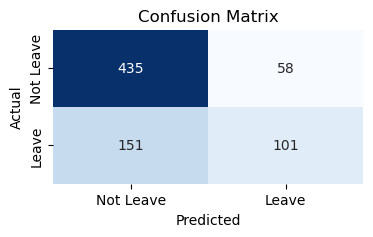

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.88      0.81       493
           1       0.64      0.40      0.49       252

    accuracy                           0.72       745
   macro avg       0.69      0.64      0.65       745
weighted avg       0.71      0.72      0.70       745



In [15]:
# Evaluate the model using confusion matrix. the predictions using the best estimator
y_pred = best_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Leave', 'Leave'], yticklabels=['Not Leave', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

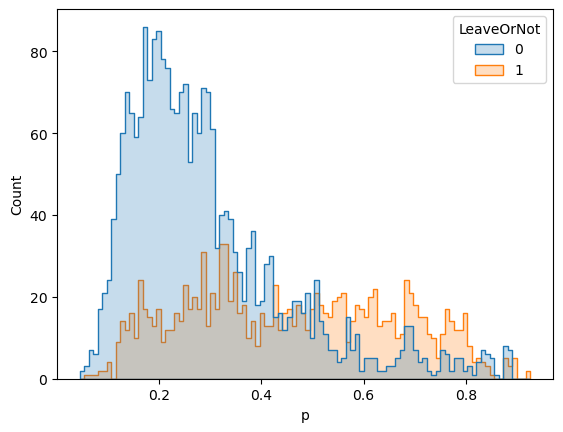

In [16]:
# Illustrative of the probability to leave or not

y_proba = best_clf.predict_proba(X)

leave_probs = pd.DataFrame(y_proba,
                         columns=[f'P({x})' for x in best_clf.classes_],
                         index=data.index)
data_joined = data.join(leave_probs)

df = {"p":data_joined["P(1)"].tolist(),
      "LeaveOrNot" :data_joined['LeaveOrNot']};

ax = sns.histplot(df, x="p", hue="LeaveOrNot",bins=100, element="step")

In [ ]:
selected_columns = ['City', 'Education', 'Race']

X_selected = data[selected_columns]
y = data['LeaveOrNot']
                                                              
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


# Define the preprocessing steps for the selected columns
selected_features_preprocessor = ColumnTransformer(transformers=[('selected_features', 'passthrough', selected_columns)])
                                                                 # 'passthrough' means no transformation
    
# Combine the selected features preprocessing with the original preprocessing pipeline
full_preprocess_pipeline = Pipeline([('feature_selection', selected_features_preprocessor),
                                     ('col_transformer', column_transformer)])


lr_model = LogisticRegression()


# Update the logistic regression pipeline
lr_pipeline = Pipeline([
    ('preprocessing', full_preprocess_pipeline),
    ('logistic_regression', lr_model)
])


# Define hyperparameters for grid search
lr_params = {'logistic_regression__C': [1, 5, 10],
              'logistic_regression__tol': [0.001, 0.0001, 0.00001]}

gs = GridSearchCV(lr_pipeline, param_grid=lr_params, cv=10, scoring='f1')
gs.fit(X_train, y_train)

best_clf = gs.best_estimator_

print("Best F1 Score:", gs.best_score_)